In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import geopandas as gpd
import os
import sys
import numpy as np
import seaborn as sns

data_destinations = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/destinations'
data_differences = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/differences'
data_social = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/social'
data_filtered_destinations = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/filtered_destinations'

zipcode_file = pathlib.Path("/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/tl_2017_us_zcta510.zip")
# Check existence
if zipcode_file.exists():
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
else:
    print("File not found! Make sure it's in the current directory.")

types = ['gender', 'household', 'family', 'nonfamily', 'married', 'race']
upperbounds = [18, 10, 10, 10, 10, 9]

sns.set_theme(style="whitegrid")
color = sns.color_palette("coolwarm", as_cmap=True)

In [15]:
def plot_heatmap_on_map(df, type, city, percentage=False):
    """
    Function to plot the heatmap of the social mixing index for the city's stations on a map

    Args:
        df (DataFrame): DataFrame with the indexes percentage (0-1)
        type (str): the type of index to plot
        city (str): the city name
    """
    
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
    # merge the two DataFrames
    merged = zipcode_gdf.merge(df, left_on='ZCTA5CE10', right_on='zipcode')
    
    # plot the map
    if percentage:
        # fix the colorbar to be between 0 and 1
        merged.plot(column=type, legend=True, cmap=color, vmin=0, vmax=1, legend_kwds={'label': "Social Mixing Index (0-1)"}, missing_kwds={"color": "lightgrey"})
    else:
        merged.plot(column=type, legend=True, cmap=color, legend_kwds={'label': "Social Mixing Index"}, missing_kwds={"color": "lightgrey"})
    
    plt.title(f'Social Mixing Index for {city} (type: {type})')
    plt.show()

In [16]:
def types_percentage(row):
    """
    Function to get the percentage of values for each type

    Args:
        row (Series): the row with the indexes
    """
    
    # for each type get the corresponding upperbound
    for type, upperbound in zip(types, upperbounds):
        row[type] = row[type] / np.log(upperbound)
    return row

def get_percentage_values(df):
    """
    Function to get the percentage of values for each type

    Args:
        df (DataFrame): the DataFrame with the indexes
    """
    
    df = df.apply(types_percentage, axis=1)
    return df

def get_zipcodes_lists(city):
    """
    Function to get the list of zipcodes of a city
    
    Args:
        city (str): the city name
        
    Returns:
        zipcodes (list): list with the zipcodes of the city
    """
    
    path = os.path.join(data_social, city, '2022')
    zipcodes = []
    
    for zipcode in os.listdir(path):
        zipcodes.append(zipcode)
    
    return zipcodes

def get_zipcodes(df, zipcode):
    """
    Function to get the mean indexes for a certain zipcode

    Args:
        city (str): the city name
        zipcode (str): the zipcode to get the indexes
    """
    
    df = df.dropna()
    df = df[df['zipcode'] == zipcode]
    
    return df

def get_means(city, destination_df):
    """
    Function to get the mean indexes for each zipcode.
    We need to get the indexes of all the stations in a zipcode and then calculate the mean.

    Args:
        city (str): the city name

    Returns:
        new_df (DataFrame): the DataFrame with the mean indexes for each zipcode
    """
    
    zipcodes = get_zipcodes_lists(city)
    indexes = list()
    
    for zipcode in zipcodes:
        # get the stations of in a specific zipcode
        df = get_zipcodes(destination_df, zipcode)
        if df.empty:
            continue
        
        # get the mean for each type
        means = {
            type: np.mean(df[type]) for type in types
        }
        
        line = {'zipcode': zipcode}
        for type, value in means.items():
            line[type] = value
            
        # insert the indexes in the list
        indexes.append(line)
        
    mean_df = pd.DataFrame(indexes)
    return mean_df

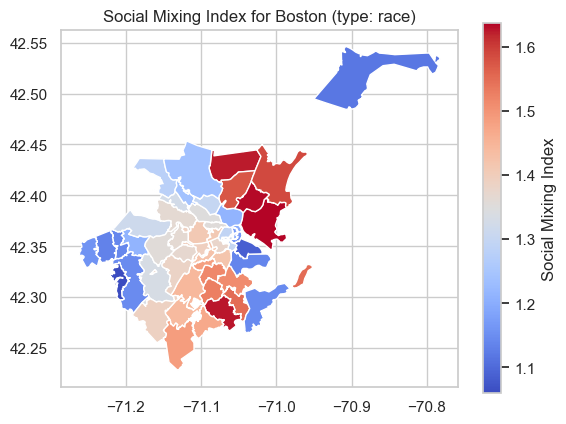

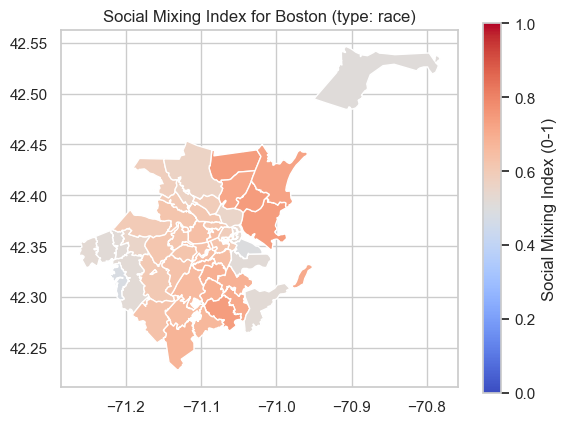

In [31]:
city = 'Boston'
type = 'race'
filtered = True

if filtered:
    data = data_filtered_destinations
else:
    data = data_destinations

df = pd.read_csv(os.path.join(data, city) + '.csv', encoding='cp1252', dtype={'zipcode': str})

df = get_means(city, df)
plot_heatmap_on_map(df, type, city)

df = get_percentage_values(df)
plot_heatmap_on_map(df, type, city, percentage=True)

# race
# Chicago low
# Columbus mix -> division
# NYC high
# SF high
# Washington mix -> division

# age